### LangGraph

In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [ ]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

load_dotenv()

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

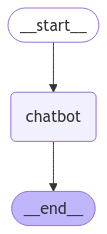

In [3]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

👆👆 Wow this can be super cool!

In [4]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Bonjour ! Comment puis-je vous aider aujourd'hui ?
Goodbye!


### Adding search tool and code execution

In [ ]:
from langchain_core.tools import tool
from duckduckgo_search import DDGS
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import HumanMessage
from langchain.callbacks.tracers import ConsoleCallbackHandler


class AgentState(MessagesState):
    # The 'next' field indicates where to route to next
    next: str


@tool("search_tool")
def search(query: str) -> str:
    """Performs web search"""
    results = DDGS().text(query, max_results=7)
    return results


from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o").with_config({"callbacks": [ConsoleCallbackHandler()]})

search_agent = create_react_agent(llm, tools=[search])


def search_node(state: AgentState) -> AgentState:
    result = search_agent.invoke(state)
    return {
        "messages": [
            HumanMessage(content=result["messages"][-1].content, name="search")
        ]
    }

In [ ]:
from langchain_experimental.utilities import PythonREPL

repl = PythonREPL()


@tool
def python_repl(code: Annotated[str, "code as a string"]):
    "Executes your code"
    try:
        result = repl.run(code)
        print("RESULT OF CODE EXECUTION", result)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return result


code_agent = create_react_agent(llm, tools=[python_repl])


def code_node(state: AgentState) -> AgentState:
    result = code_agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name="code")]
    }

In [31]:
code_agent

In [ ]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: MessagesState) -> MessagesState:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        next_ = response["next"]
        if next_ == "FINISH":
            next_ = END

        return {"next": next_}

    return supervisor_node


research_supervisor_node = make_supervisor_node(llm, ["search", "code"])

In [33]:
research_builder = StateGraph(MessagesState)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("code", code_node)

# Define the control flow
research_builder.add_edge(START, "supervisor")
# We want our workers to ALWAYS "report back" to the supervisor when done
research_builder.add_edge("search", "supervisor")
research_builder.add_edge("code", "supervisor")
# Add the edges where routing applies
research_builder.add_conditional_edges("supervisor", lambda state: state["next"])

research_graph = research_builder.compile()

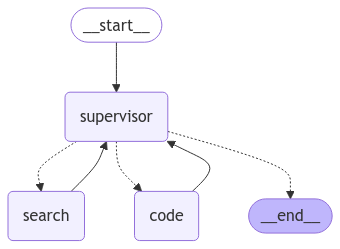

In [34]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [ ]:
for s in research_graph.stream(
    {
        "messages": [
            (
                "user",
                "What's the Pope's current age, power 0.82? You have to do the calculation in code",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content='Pope Francis is currently 87 years old. To find the result of his age raised to the power of 0.82, we can perform the calculation:\n\n\\[ 87^{0.82} \\approx 45.65 \\]\n\nSo, 87 to the power of 0.82 is approximately 45.65.', additional_kwargs={}, response_metadata={}, name='search', id='f74c2e0d-15df-4a03-9ed4-6b62107e68e3')]}}
---
{'supervisor': {'next': 'code'}}
---
RESULT OF CODE EXECUTION 
{'code': {'messages': [HumanMessage(content='The calculation of 87 to the power of 0.82 is approximately 45.65.', additional_kwargs={}, response_metadata={}, name='code', id='355ea200-5b9c-4ee3-a57f-3a73febd4365')]}}
---
{'supervisor': {'next': '__end__'}}
---


This worked! 🥳